# 범죄현황 데이터 EDA

In [1]:
import pandas as pd

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns

In [20]:
from matplotlib import rc

rc('font', family='AppleGothic')

In [2]:
crime = pd.read_csv("../data_final/서울시_범죄현황.csv")
crime

,city_name,county_name,total_crime,total_arrest,murder_crime,murder_arrest,robbery_crime,robbery_arrest,sex_crime,sex_arrest,theft_crime,theft_arrest,violence_crime,violence_arrest
0,서울,종로구,3138,3284,2,3,8,8,228,988,1313,932,1587,1353
1,서울,중구,3071,2119,1,2,5,4,194,123,1365,724,1506,1266
2,서울,용산구,2967,2093,5,3,7,7,280,238,978,508,1697,1337
3,서울,성동구,2194,1597,2,2,2,2,125,97,979,538,1086,958
4,서울,광진구,3619,2498,6,5,-,-,230,174,1670,831,1713,1488
5,서울,동대문구,3253,2231,4,4,2,2,125,106,1556,823,1566,1296
6,서울,중랑구,3599,2671,2,2,2,2,150,121,1508,882,1937,1664
7,서울,성북구,2749,2125,3,3,1,1,158,129,1143,715,1444,1277
8,서울,강북구,2832,2343,5,4,5,6,177,147,872,589,1773,1597
9,서울,도봉구,2141,1569,3,3,-,-,70,54,969,546,1099,966


## BigQuery 연결

In [3]:
!pip install google-cloud-bigquery google-auth db-dtypes

In [4]:
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file("./data/key.json")

In [5]:
from google.cloud import bigquery

client = bigquery.Client(
    credentials=credentials,
    project=credentials.project_id
)

In [14]:
crime_pop = '''
SELECT
  crime.county_name,
  pop.total as population,
  sum(total_crime) as total,
  sum(murder_crime) as murder,
  sum(IF(robbery_crime = '-', 0, CAST(robbery_crime AS INT64))) as robbery,
  sum(sex_crime) as sex,
  sum(theft_crime) as theft,
  sum(violence_crime) as violence
FROM 
  `my-fantazip.fantazip.population_by_age` as pop
INNER JOIN
  `my-fantazip.fantazip.crime` as crime
ON
  pop.county_name = crime.county_name
GROUP BY
  crime.county_name,
  pop.total
'''

In [15]:
crime_pop = client.query(crime_pop).to_dataframe()
crime_pop

,county_name,population,total,murder,robbery,sex,theft,violence
0,중구,701,3071,1,5,194,1365,1506
1,중구,261,3071,1,5,194,1365,1506
2,중구,1554,3071,1,5,194,1365,1506
3,중구,597,3071,1,5,194,1365,1506
4,중구,845,3071,1,5,194,1365,1506
...,...,...,...,...,...,...,...,...
441,영등포구,13729,4819,5,10,327,2062,2415
442,영등포구,4599,4819,5,10,327,2062,2415
443,영등포구,8231,4819,5,10,327,2062,2415
444,영등포구,1964,4819,5,10,327,2062,2415


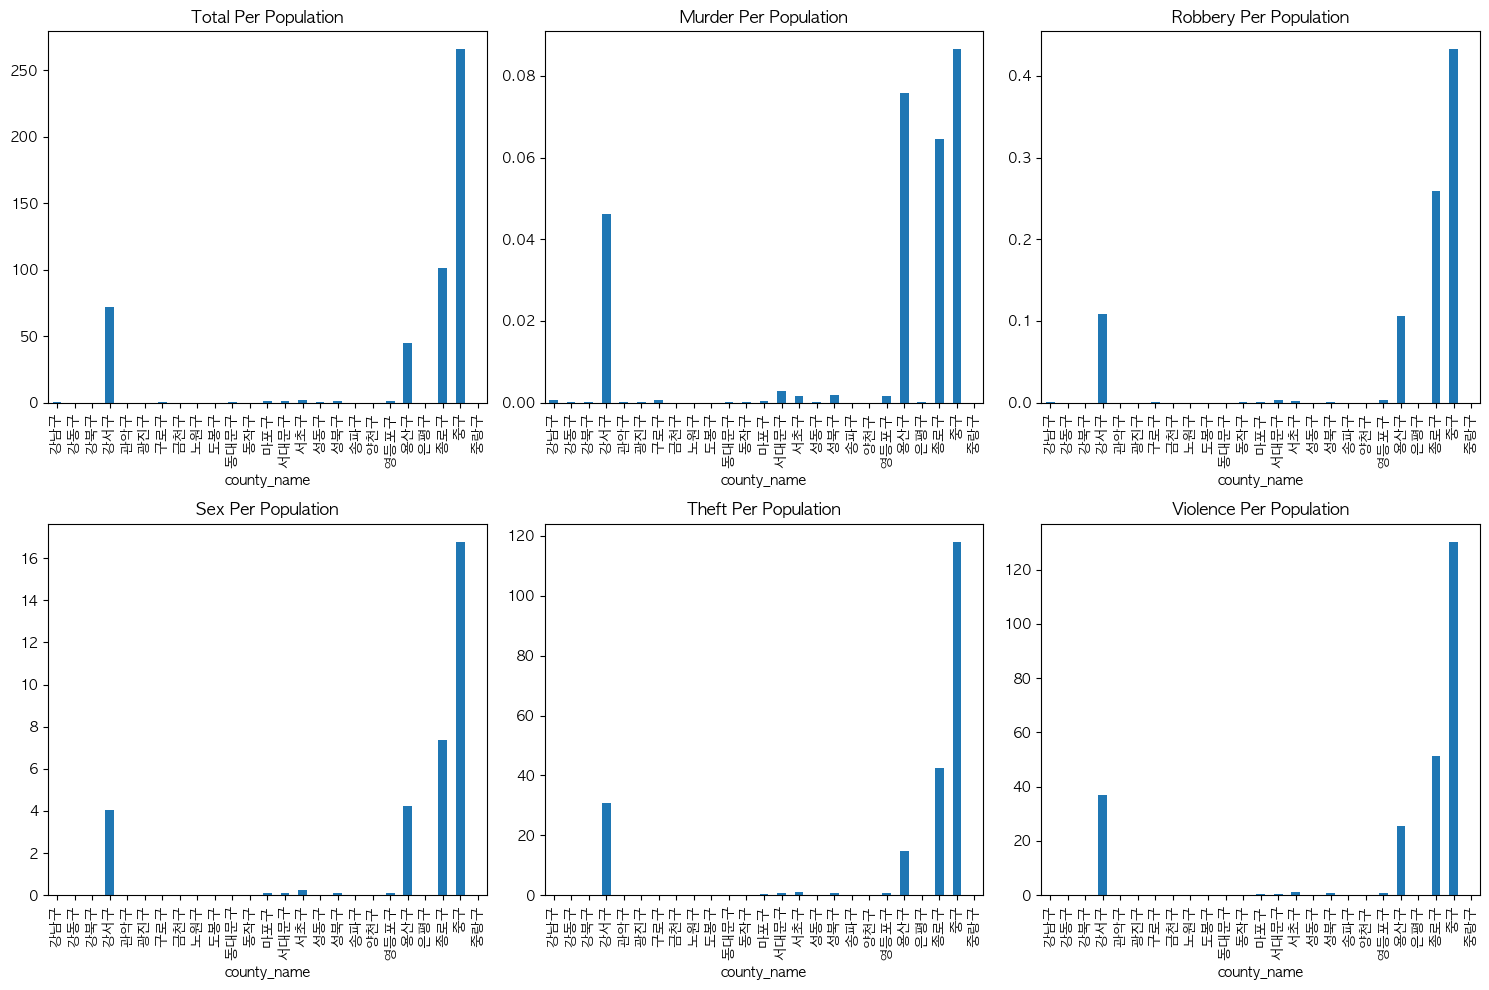

In [21]:
# 인구 대비 발생률 계산
crime_pop['total_per_pop'] = crime_pop['total'] / crime_pop['population']
crime_pop['murder_per_pop'] = crime_pop['murder'] / crime_pop['population']
crime_pop['robbery_per_pop'] = crime_pop['robbery'] / crime_pop['population']
crime_pop['sex_per_pop'] = crime_pop['sex'] / crime_pop['population']
crime_pop['theft_per_pop'] = crime_pop['theft'] / crime_pop['population']
crime_pop['violence_per_pop'] = crime_pop['violence'] / crime_pop['population']

# "county_name"별로 그래프 그리기
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
crime_pop.groupby('county_name')['total_per_pop'].mean().plot(kind='bar', ax=axes[0, 0], title='Total Per Population')
crime_pop.groupby('county_name')['murder_per_pop'].mean().plot(kind='bar', ax=axes[0, 1], title='Murder Per Population')
crime_pop.groupby('county_name')['robbery_per_pop'].mean().plot(kind='bar', ax=axes[0, 2], title='Robbery Per Population')
crime_pop.groupby('county_name')['sex_per_pop'].mean().plot(kind='bar', ax=axes[1, 0], title='Sex Per Population')
crime_pop.groupby('county_name')['theft_per_pop'].mean().plot(kind='bar', ax=axes[1, 1], title='Theft Per Population')
crime_pop.groupby('county_name')['violence_per_pop'].mean().plot(kind='bar', ax=axes[1, 2], title='Violence Per Population')

plt.tight_layout()
plt.show()

In [25]:
arrest_pop = '''
SELECT
  crime.county_name,
  pop.total as population,
  sum(total_arrest) as total,
  sum(murder_arrest) as murder,
  sum(IF(robbery_arrest = '-', 0, CAST(robbery_crime AS INT64))) as robbery,
  sum(sex_arrest) as sex,
  sum(theft_arrest) as theft,
  sum(violence_arrest) as violence
FROM 
  `my-fantazip.fantazip.population_by_age` as pop
INNER JOIN
  `my-fantazip.fantazip.crime` as crime
ON
  pop.county_name = crime.county_name
GROUP BY
  crime.county_name,
  pop.total
'''

In [26]:
arrest_pop = client.query(arrest_pop).to_dataframe()
arrest_pop

,county_name,population,total,murder,robbery,sex,theft,violence
0,중구,701,2119,2,5,123,724,1266
1,중구,261,2119,2,5,123,724,1266
2,중구,1554,2119,2,5,123,724,1266
3,중구,597,2119,2,5,123,724,1266
4,중구,845,2119,2,5,123,724,1266
...,...,...,...,...,...,...,...,...
441,영등포구,13729,3186,6,10,237,953,1981
442,영등포구,4599,3186,6,10,237,953,1981
443,영등포구,8231,3186,6,10,237,953,1981
444,영등포구,1964,3186,6,10,237,953,1981


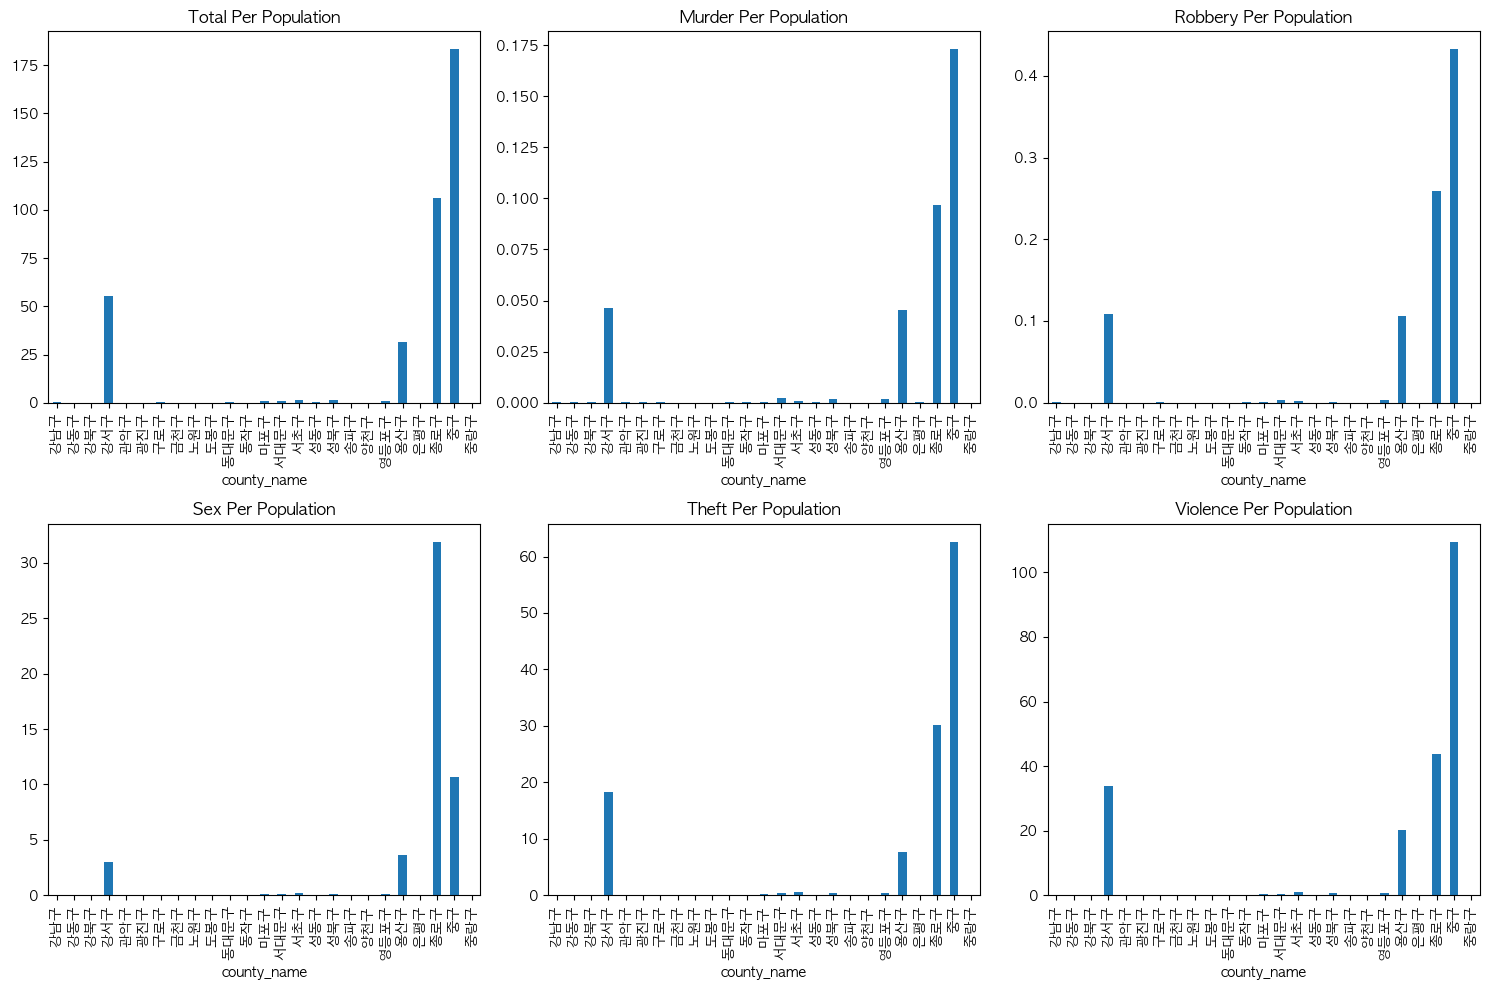

In [27]:
# 인구 대비 발생률 계산
arrest_pop['total_per_pop'] = arrest_pop['total'] / arrest_pop['population']
arrest_pop['murder_per_pop'] = arrest_pop['murder'] / arrest_pop['population']
arrest_pop['robbery_per_pop'] = arrest_pop['robbery'] / arrest_pop['population']
arrest_pop['sex_per_pop'] = arrest_pop['sex'] / arrest_pop['population']
arrest_pop['theft_per_pop'] = arrest_pop['theft'] / arrest_pop['population']
arrest_pop['violence_per_pop'] = arrest_pop['violence'] / arrest_pop['population']

# "county_name"별로 그래프 그리기
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
arrest_pop.groupby('county_name')['total_per_pop'].mean().plot(kind='bar', ax=axes[0, 0], title='Total Per Population')
arrest_pop.groupby('county_name')['murder_per_pop'].mean().plot(kind='bar', ax=axes[0, 1], title='Murder Per Population')
arrest_pop.groupby('county_name')['robbery_per_pop'].mean().plot(kind='bar', ax=axes[0, 2], title='Robbery Per Population')
arrest_pop.groupby('county_name')['sex_per_pop'].mean().plot(kind='bar', ax=axes[1, 0], title='Sex Per Population')
arrest_pop.groupby('county_name')['theft_per_pop'].mean().plot(kind='bar', ax=axes[1, 1], title='Theft Per Population')
arrest_pop.groupby('county_name')['violence_per_pop'].mean().plot(kind='bar', ax=axes[1, 2], title='Violence Per Population')

plt.tight_layout()
plt.show()

In [28]:
crime_pop

,county_name,population,total,murder,robbery,sex,theft,violence,total_per_pop,murder_per_pop,robbery_per_pop,sex_per_pop,theft_per_pop,violence_per_pop
0,중구,701,3071,1,5,194,1365,1506,4.380884,0.001427,0.007133,0.276748,1.947218,2.148359
1,중구,261,3071,1,5,194,1365,1506,11.766284,0.003831,0.019157,0.743295,5.229885,5.770115
2,중구,1554,3071,1,5,194,1365,1506,1.97619,0.000644,0.003218,0.124839,0.878378,0.969112
3,중구,597,3071,1,5,194,1365,1506,5.144054,0.001675,0.008375,0.324958,2.286432,2.522613
4,중구,845,3071,1,5,194,1365,1506,3.63432,0.001183,0.005917,0.229586,1.615385,1.782249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,영등포구,13729,4819,5,10,327,2062,2415,0.351009,0.000364,0.000728,0.023818,0.150193,0.175905
442,영등포구,4599,4819,5,10,327,2062,2415,1.047836,0.001087,0.002174,0.071102,0.448358,0.525114
443,영등포구,8231,4819,5,10,327,2062,2415,0.58547,0.000607,0.001215,0.039728,0.250516,0.293403
444,영등포구,1964,4819,5,10,327,2062,2415,2.453666,0.002546,0.005092,0.166497,1.049898,1.229633


# 여기가 진짜야!
### total_crime

In [99]:
population = crime_pop.groupby("county_name")["population"].sum().reset_index(name='pop')
population

,county_name,pop
0,강남구,549154
1,강동구,459389
2,강북구,287490
3,강서구,562550
4,관악구,481872
5,광진구,335335
6,구로구,392311
7,금천구,227457
8,노원구,497237
9,도봉구,306722


In [101]:
total_sum = crime_pop.groupby("county_name")["total"].sum().reset_index(name='total_cnt')
total_sum

,county_name,total_cnt
0,강남구,97258
1,강동구,33399
2,강북구,11328
3,강서구,55956
4,관악구,14637
5,광진구,25333
6,구로구,38570
7,금천구,7731
8,노원구,19480
9,도봉구,8564


In [104]:
total_per_pop = pd.merge(population, total_sum, on="county_name", how="inner")
total_per_pop["total_ratio"] = total_per_pop["total_cnt"] / total_per_pop["pop"]
total_per_pop

,county_name,pop,total_cnt,total_ratio
0,강남구,549154,97258,0.177105
1,강동구,459389,33399,0.072703
2,강북구,287490,11328,0.039403
3,강서구,562550,55956,0.099468
4,관악구,481872,14637,0.030375
5,광진구,335335,25333,0.075545
6,구로구,392311,38570,0.098315
7,금천구,227457,7731,0.033989
8,노원구,497237,19480,0.039176
9,도봉구,306722,8564,0.027921


In [106]:
total_per_pop.describe()

,pop,total_cnt,total_ratio
count,25.0,25.0,25.0
mean,375356.8,63310.12,0.264707
std,127587.159427,65449.923094,0.48676
min,121001.0,7731.0,0.021828
25%,305857.0,21594.0,0.056487
50%,378360.0,38357.0,0.098315
75%,459389.0,97258.0,0.177105
max,653989.0,263592.0,1.892343


Text(0, 0.5, 'total_ratio')

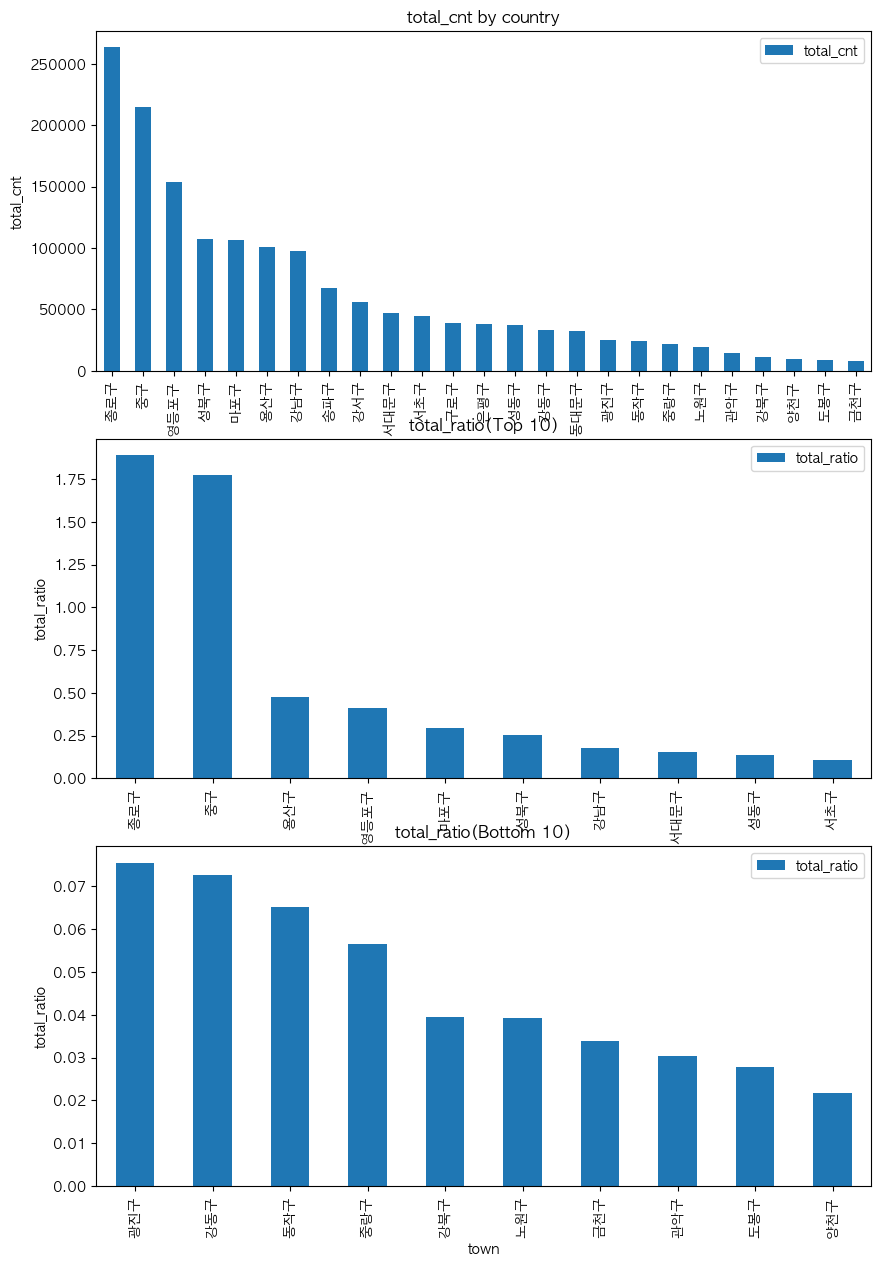

In [105]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
total_per_pop.sort_values(by='total_cnt', ascending=False).plot(kind='bar', x='county_name', y='total_cnt', ax=axes[0])
axes[0].set_title('total_cnt by country')
axes[0].set_xlabel('county')
axes[0].set_ylabel('total_cnt')

total_per_pop.sort_values(by='total_ratio', ascending=False).head(10).plot(kind='bar', x='county_name', y='total_ratio', ax=axes[1])
axes[1].set_title('total_ratio(Top 10)')
axes[1].set_xlabel('town')
axes[1].set_ylabel('total_ratio')

total_per_pop.sort_values(by='total_ratio', ascending=False).tail(10).plot(kind='bar', x='county_name', y='total_ratio', ax=axes[2])
axes[2].set_title('total_ratio(Bottom 10)')
axes[2].set_xlabel('town')
axes[2].set_ylabel('total_ratio')

### murder_crime

In [107]:
murder_sum = crime_pop.groupby("county_name")["murder"].sum().reset_index(name='murder_cnt')
murder_sum

,county_name,murder_cnt
0,강남구,168
1,강동구,45
2,강북구,20
3,강서구,36
4,관악구,30
5,광진구,42
6,구로구,110
7,금천구,6
8,노원구,15
9,도봉구,12


In [110]:
murder_per_pop = pd.merge(population, murder_sum, on="county_name", how="inner")
murder_per_pop["murder_ratio"] = murder_per_pop["murder_cnt"] / murder_per_pop["pop"]
murder_per_pop

,county_name,pop,murder_cnt,murder_ratio
0,강남구,549154,168,0.000306
1,강동구,459389,45,0.000098
2,강북구,287490,20,0.00007
3,강서구,562550,36,0.000064
4,관악구,481872,30,0.000062
5,광진구,335335,42,0.000125
6,구로구,392311,110,0.00028
7,금천구,227457,6,0.000026
8,노원구,497237,15,0.00003
9,도봉구,306722,12,0.000039


In [112]:
murder_per_pop.describe()

,pop,murder_cnt,murder_ratio
count,25.0,25.0,25.0
mean,375356.8,61.24,0.000216
std,127587.159427,55.581981,0.000282
min,121001.0,6.0,0.000014
25%,305857.0,20.0,0.000048
50%,378360.0,40.0,0.000098
75%,459389.0,100.0,0.00028
max,653989.0,170.0,0.001206


Text(0, 0.5, 'murder_ratio')

/Users/oyujeong/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/Users/oyujeong/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


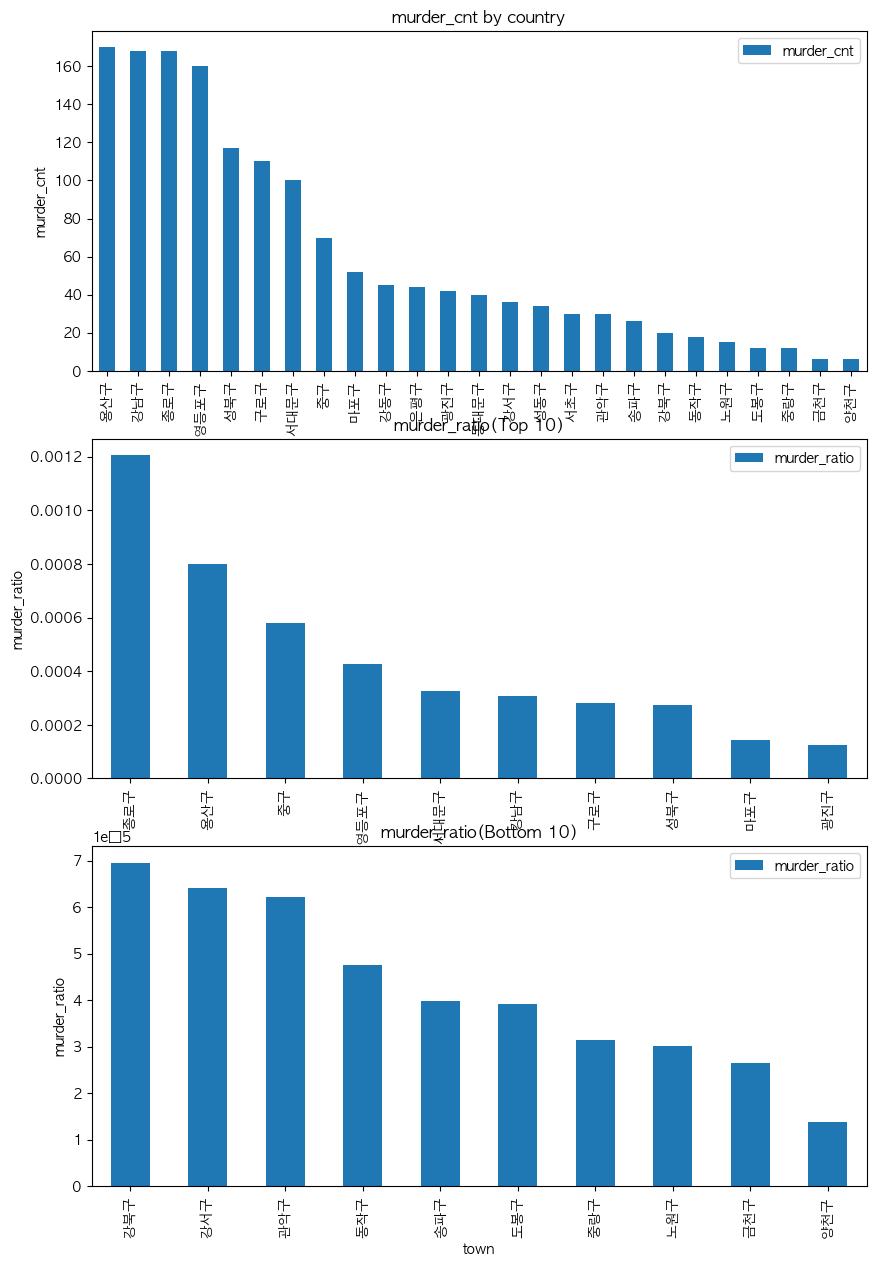

In [113]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
murder_per_pop.sort_values(by='murder_cnt', ascending=False).plot(kind='bar', x='county_name', y='murder_cnt', ax=axes[0])
axes[0].set_title('murder_cnt by country')
axes[0].set_xlabel('county')
axes[0].set_ylabel('murder_cnt')

murder_per_pop.sort_values(by='murder_ratio', ascending=False).head(10).plot(kind='bar', x='county_name', y='murder_ratio', ax=axes[1])
axes[1].set_title('murder_ratio(Top 10)')
axes[1].set_xlabel('town')
axes[1].set_ylabel('murder_ratio')

murder_per_pop.sort_values(by='murder_ratio', ascending=False).tail(10).plot(kind='bar', x='county_name', y='murder_ratio', ax=axes[2])
axes[2].set_title('murder_ratio(Bottom 10)')
axes[2].set_xlabel('town')
axes[2].set_ylabel('murder_ratio')

### robbery_crime

In [114]:
robbery_sum = crime_pop.groupby("county_name")["robbery"].sum().reset_index(name='robbery_cnt')
robbery_sum

,county_name,robbery_cnt
0,강남구,154
1,강동구,45
2,강북구,20
3,강서구,84
4,관악구,27
5,광진구,0
6,구로구,80
7,금천구,9
8,노원구,15
9,도봉구,0


In [115]:
robbery_per_pop = pd.merge(population, robbery_sum, on="county_name", how="inner")
robbery_per_pop["robbery_ratio"] = robbery_per_pop["robbery_cnt"] / robbery_per_pop["pop"]
robbery_per_pop

,county_name,pop,robbery_cnt,robbery_ratio
0,강남구,549154,154,0.00028
1,강동구,459389,45,0.000098
2,강북구,287490,20,0.00007
3,강서구,562550,84,0.000149
4,관악구,481872,27,0.000056
5,광진구,335335,0,0.0
6,구로구,392311,80,0.000204
7,금천구,227457,9,0.00004
8,노원구,497237,15,0.00003
9,도봉구,306722,0,0.0


In [116]:
robbery_per_pop.describe()

,pop,robbery_cnt,robbery_ratio
count,25.0,25.0,25.0
mean,375356.8,99.8,0.000476
std,127587.159427,152.115636,0.001087
min,121001.0,0.0,0.0
25%,305857.0,20.0,0.000056
50%,378360.0,45.0,0.000099
75%,459389.0,84.0,0.000204
max,653989.0,672.0,0.004824


Text(0, 0.5, 'murder_ratio')

/Users/oyujeong/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/Users/oyujeong/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


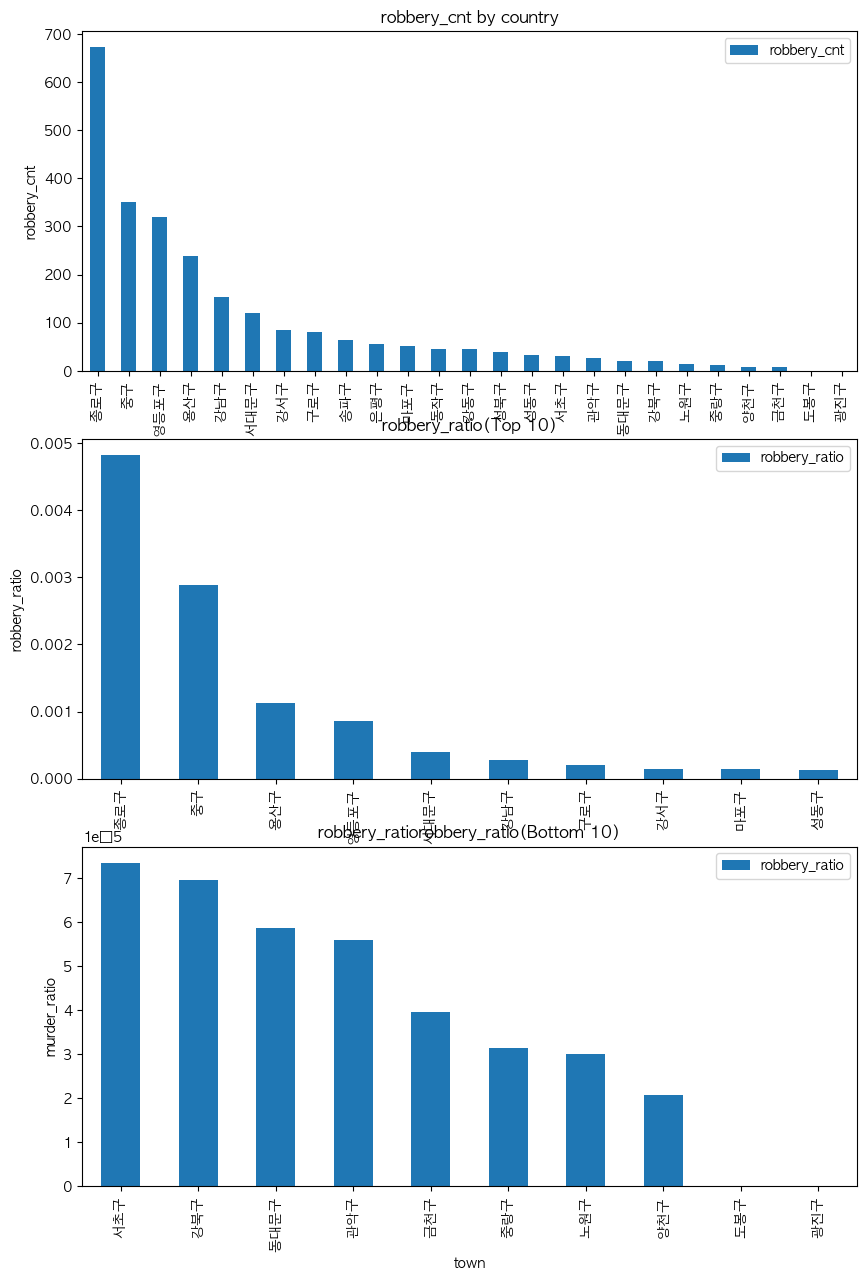

In [117]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
robbery_per_pop.sort_values(by='robbery_cnt', ascending=False).plot(kind='bar', x='county_name', y='robbery_cnt', ax=axes[0])
axes[0].set_title('robbery_cnt by country')
axes[0].set_xlabel('county')
axes[0].set_ylabel('robbery_cnt')

robbery_per_pop.sort_values(by='robbery_ratio', ascending=False).head(10).plot(kind='bar', x='county_name', y='robbery_ratio', ax=axes[1])
axes[1].set_title('robbery_ratio(Top 10)')
axes[1].set_xlabel('town')
axes[1].set_ylabel('robbery_ratio')

robbery_per_pop.sort_values(by='robbery_ratio', ascending=False).tail(10).plot(kind='bar', x='county_name', y='robbery_ratio', ax=axes[2])
axes[2].set_title('robbery_ratiorobbery_ratio(Bottom 10)')
axes[2].set_xlabel('town')
axes[2].set_ylabel('murder_ratio')

### sex_crime

In [118]:
sex_sum = crime_pop.groupby("county_name")["sex"].sum().reset_index(name='sex_cnt')
sex_sum

,county_name,sex_cnt
0,강남구,9338
1,강동구,1413
2,강북구,708
3,강서구,3132
4,관악구,981
5,광진구,1610
6,구로구,2170
7,금천구,381
8,노원구,900
9,도봉구,280


In [121]:
sex_per_pop = pd.merge(population, sex_sum, on="county_name", how="inner")
sex_per_pop["sex_ratio"] = sex_per_pop["sex_cnt"] / sex_per_pop["pop"]
sex_per_pop

,county_name,pop,sex_cnt,sex_ratio
0,강남구,549154,9338,0.017004
1,강동구,459389,1413,0.003076
2,강북구,287490,708,0.002463
3,강서구,562550,3132,0.005568
4,관악구,481872,981,0.002036
5,광진구,335335,1610,0.004801
6,구로구,392311,2170,0.005531
7,금천구,227457,381,0.001675
8,노원구,497237,900,0.00181
9,도봉구,306722,280,0.000913


In [122]:
sex_per_pop.describe()

,pop,sex_cnt,sex_ratio
count,25.0,25.0,25.0
mean,375356.8,4432.32,0.018533
std,127587.159427,4968.754444,0.033948
min,121001.0,280.0,0.000785
25%,305857.0,981.0,0.002463
50%,378360.0,2125.0,0.005531
75%,459389.0,6162.0,0.014502
max,653989.0,19152.0,0.137493


Text(0, 0.5, 'sex_ratio')

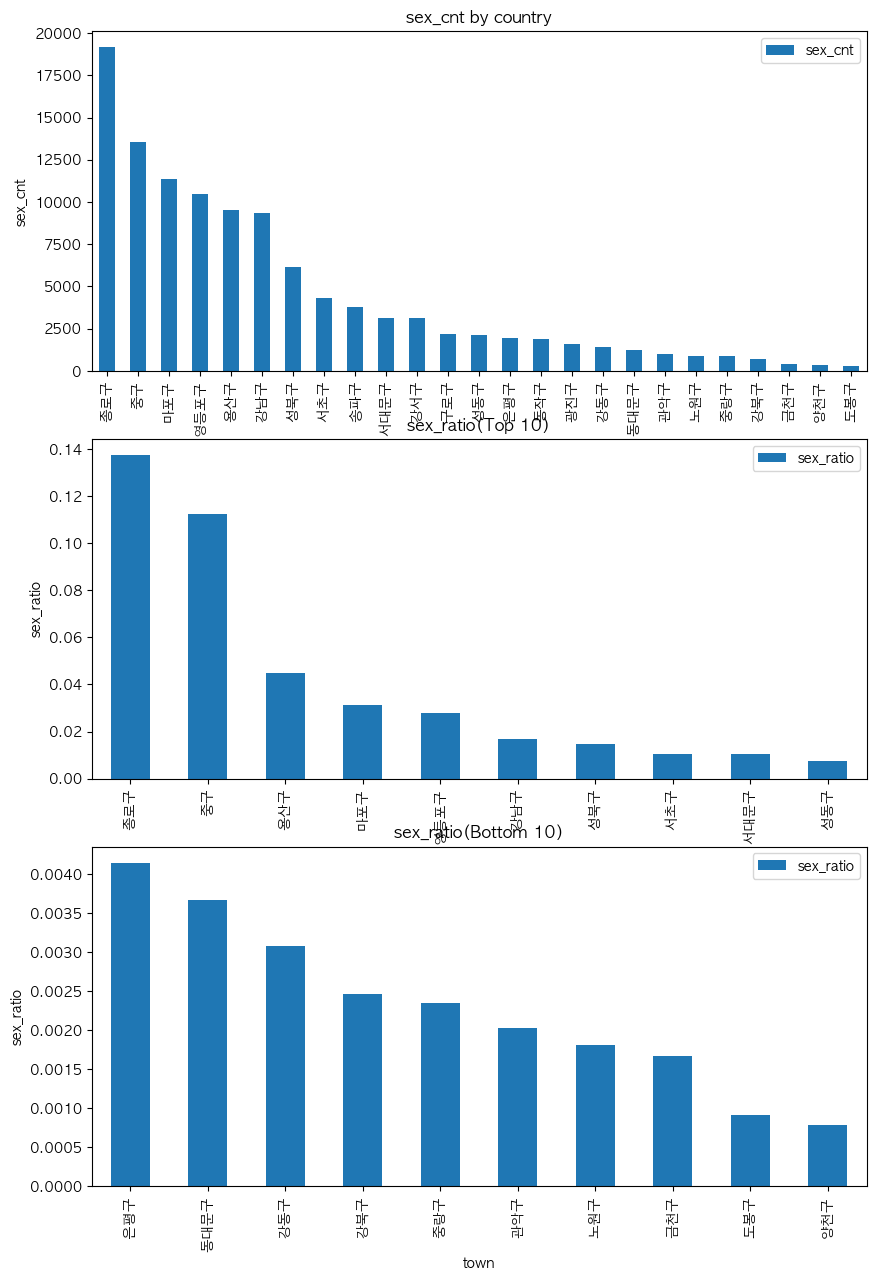

In [123]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
sex_per_pop.sort_values(by='sex_cnt', ascending=False).plot(kind='bar', x='county_name', y='sex_cnt', ax=axes[0])
axes[0].set_title('sex_cnt by country')
axes[0].set_xlabel('county')
axes[0].set_ylabel('sex_cnt')

sex_per_pop.sort_values(by='sex_ratio', ascending=False).head(10).plot(kind='bar', x='county_name', y='sex_ratio', ax=axes[1])
axes[1].set_title('sex_ratio(Top 10)')
axes[1].set_xlabel('town')
axes[1].set_ylabel('sex_ratio')

sex_per_pop.sort_values(by='sex_ratio', ascending=False).tail(10).plot(kind='bar', x='county_name', y='sex_ratio', ax=axes[2])
axes[2].set_title('sex_ratio(Bottom 10)')
axes[2].set_xlabel('town')
axes[2].set_ylabel('sex_ratio')

### theft_crime

In [124]:
theft_sum = crime_pop.groupby("county_name")["theft"].sum().reset_index(name='theft_cnt')
theft_sum

,county_name,theft_cnt
0,강남구,34930
1,강동구,15048
2,강북구,3488
3,강서구,23892
4,관악구,5898
5,광진구,11690
6,구로구,15650
7,금천구,3354
8,노원구,7520
9,도봉구,3876


In [125]:
theft_per_pop = pd.merge(population, theft_sum, on="county_name", how="inner")
theft_per_pop["theft_ratio"] = theft_per_pop["theft_cnt"] / theft_per_pop["pop"]
theft_per_pop

,county_name,pop,theft_cnt,theft_ratio
0,강남구,549154,34930,0.063607
1,강동구,459389,15048,0.032757
2,강북구,287490,3488,0.012133
3,강서구,562550,23892,0.042471
4,관악구,481872,5898,0.01224
5,광진구,335335,11690,0.034861
6,구로구,392311,15650,0.039892
7,금천구,227457,3354,0.014746
8,노원구,497237,7520,0.015124
9,도봉구,306722,3876,0.012637


In [126]:
theft_per_pop.describe()

,pop,theft_cnt,theft_ratio
count,25.0,25.0,25.0
mean,375356.8,26229.0,0.110808
std,127587.159427,27526.707813,0.209097
min,121001.0,3354.0,0.010153
25%,305857.0,9048.0,0.023668
50%,378360.0,16467.0,0.042471
75%,459389.0,33252.0,0.072844
max,653989.0,110292.0,0.791793


Text(0, 0.5, 'theft_ratio')

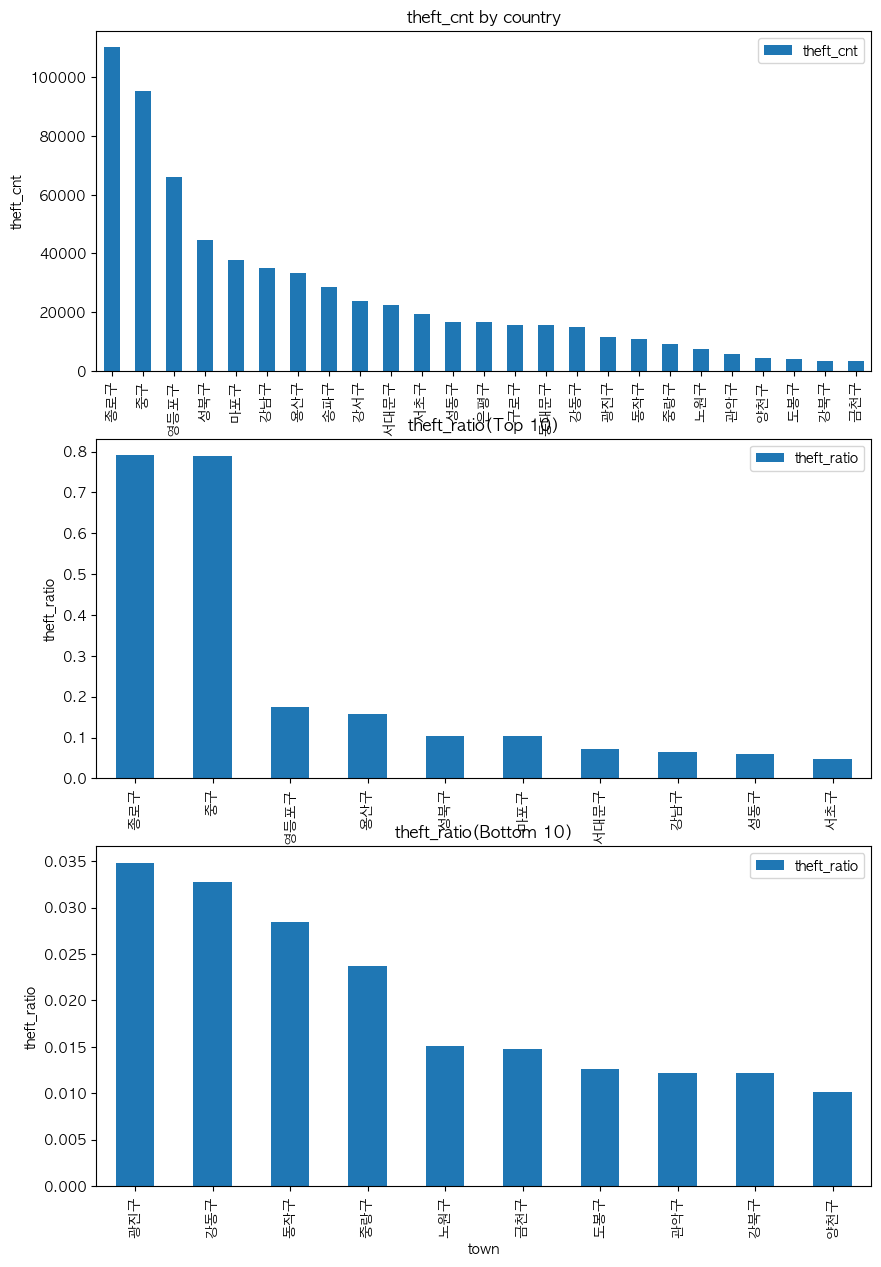

In [127]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
theft_per_pop.sort_values(by='theft_cnt', ascending=False).plot(kind='bar', x='county_name', y='theft_cnt', ax=axes[0])
axes[0].set_title('theft_cnt by country')
axes[0].set_xlabel('county')
axes[0].set_ylabel('theft_cnt')

theft_per_pop.sort_values(by='theft_ratio', ascending=False).head(10).plot(kind='bar', x='county_name', y='theft_ratio', ax=axes[1])
axes[1].set_title('theft_ratio(Top 10)')
axes[1].set_xlabel('town')
axes[1].set_ylabel('theft_ratio')

theft_per_pop.sort_values(by='theft_ratio', ascending=False).tail(10).plot(kind='bar', x='county_name', y='theft_ratio', ax=axes[2])
axes[2].set_title('theft_ratio(Bottom 10)')
axes[2].set_xlabel('town')
axes[2].set_ylabel('theft_ratio')

### violence_crime

In [132]:
violence_sum = crime_pop.groupby("county_name")["violence"].sum().reset_index(name='violence_cnt')
violence_sum

,county_name,violence_cnt
0,강남구,52668
1,강동구,16848
2,강북구,7092
3,강서구,28812
4,관악구,7701
5,광진구,11991
6,구로구,20560
7,금천구,3981
8,노원구,11030
9,도봉구,4396


In [133]:
violence_per_pop = pd.merge(population, violence_sum, on="county_name", how="inner")
violence_per_pop["violence_ratio"] = violence_per_pop["violence_cnt"] / violence_per_pop["pop"]
violence_per_pop

,county_name,pop,violence_cnt,violence_ratio
0,강남구,549154,52668,0.095908
1,강동구,459389,16848,0.036675
2,강북구,287490,7092,0.024669
3,강서구,562550,28812,0.051217
4,관악구,481872,7701,0.015981
5,광진구,335335,11991,0.035758
6,구로구,392311,20560,0.052407
7,금천구,227457,3981,0.017502
8,노원구,497237,11030,0.022183
9,도봉구,306722,4396,0.014332


In [134]:
violence_per_pop.describe()

,pop,violence_cnt,violence_ratio
count,25.0,25.0,25.0
mean,375356.8,32487.76,0.134675
std,127587.159427,33153.503423,0.243273
min,121001.0,3981.0,0.010855
25%,305857.0,11622.0,0.030401
50%,378360.0,19855.0,0.051217
75%,459389.0,52668.0,0.095908
max,653989.0,133308.0,0.957026


Text(0, 0.5, 'violence_ratio')

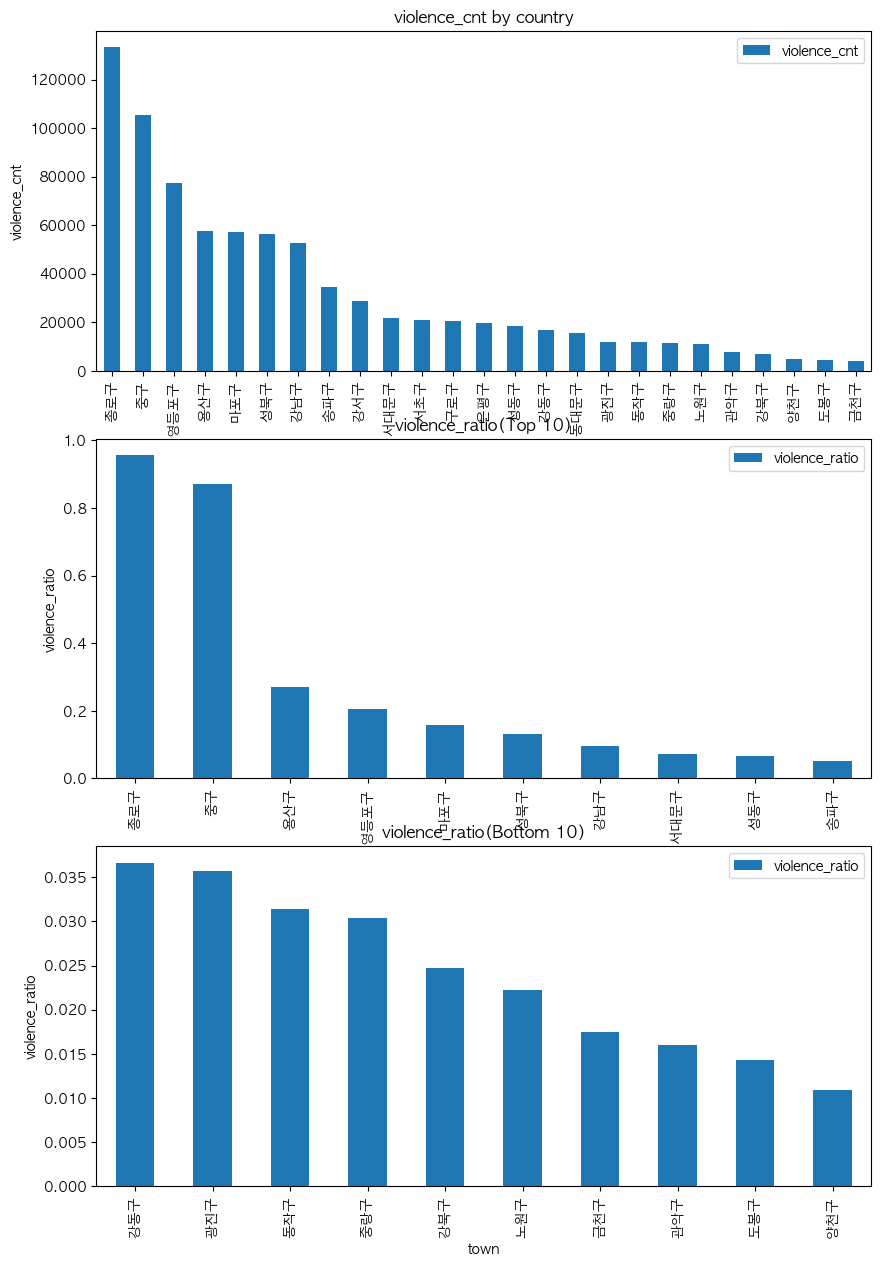

In [136]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
violence_per_pop.sort_values(by='violence_cnt', ascending=False).plot(kind='bar', x='county_name', y='violence_cnt', ax=axes[0])
axes[0].set_title('violence_cnt by country')
axes[0].set_xlabel('county')
axes[0].set_ylabel('violence_cnt')

violence_per_pop.sort_values(by='violence_ratio', ascending=False).head(10).plot(kind='bar', x='county_name', y='violence_ratio', ax=axes[1])
axes[1].set_title('violence_ratio(Top 10)')
axes[1].set_xlabel('town')
axes[1].set_ylabel('violence_ratio')

violence_per_pop.sort_values(by='violence_ratio', ascending=False).tail(10).plot(kind='bar', x='county_name', y='violence_ratio', ax=axes[2])
axes[2].set_title('violence_ratio(Bottom 10)')
axes[2].set_xlabel('town')
axes[2].set_ylabel('violence_ratio')

In [29]:
arrest_pop

,county_name,population,total,murder,robbery,sex,theft,violence,total_per_pop,murder_per_pop,robbery_per_pop,sex_per_pop,theft_per_pop,violence_per_pop
0,중구,701,2119,2,5,123,724,1266,3.022825,0.002853,0.007133,0.175464,1.03281,1.805991
1,중구,261,2119,2,5,123,724,1266,8.118774,0.007663,0.019157,0.471264,2.773946,4.850575
2,중구,1554,2119,2,5,123,724,1266,1.363578,0.001287,0.003218,0.079151,0.465894,0.814672
3,중구,597,2119,2,5,123,724,1266,3.549414,0.00335,0.008375,0.20603,1.21273,2.120603
4,중구,845,2119,2,5,123,724,1266,2.507692,0.002367,0.005917,0.145562,0.856805,1.498225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,영등포구,13729,3186,6,10,237,953,1981,0.232064,0.000437,0.000728,0.017263,0.069415,0.144293
442,영등포구,4599,3186,6,10,237,953,1981,0.692759,0.001305,0.002174,0.051533,0.207219,0.430746
443,영등포구,8231,3186,6,10,237,953,1981,0.387073,0.000729,0.001215,0.028794,0.115782,0.240675
444,영등포구,1964,3186,6,10,237,953,1981,1.6222,0.003055,0.005092,0.120672,0.485234,1.008656
